In [5]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [6]:
train = pl.read_csv("/kaggle/input/atmaCup#18_dataset/train_features.csv")
train = (
    train.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(pl.col("offset").cast(pl.Float32))
)
print(train.shape)
train.head()

(43371, 32)


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,sceneID,offset
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f32
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320.0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420.0
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be46663…",520.0
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f…",120.0
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243,"""000fb056f97572d384bae4f5fc1e0f…",20.0


In [7]:
from glob import glob

# 画像を読み込み
ID = train["ID"][0]
path = glob(os.path.join("/kaggle/input/atmaCup#18_dataset", "images", "*", "image_t.png"))
len(path)

45098

/tmp/ipykernel_37443/1008402935.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = np.array(plt.cm.get_cmap("tab20").colors) * 255


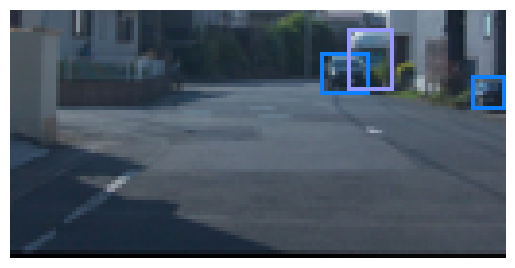

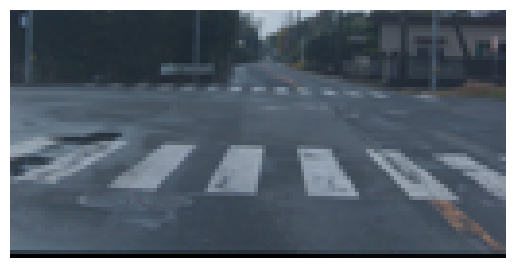

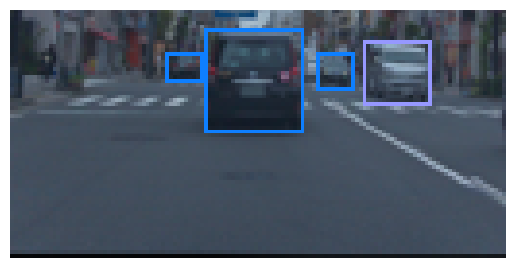

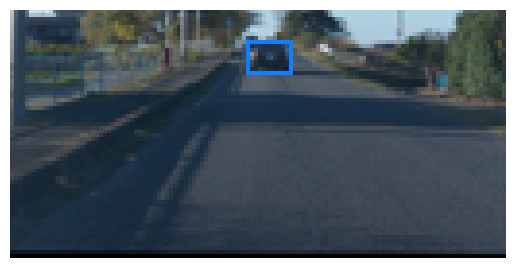

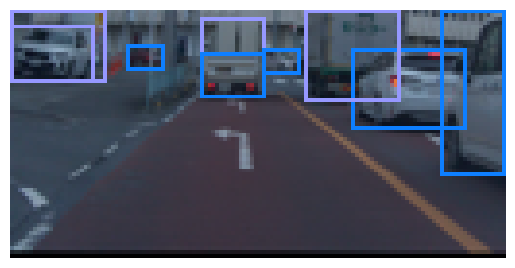

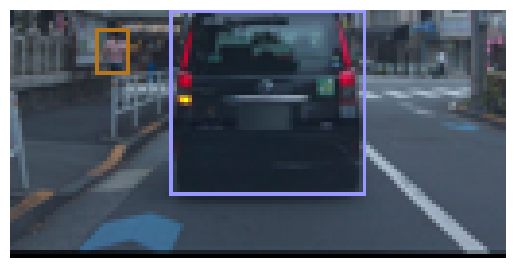

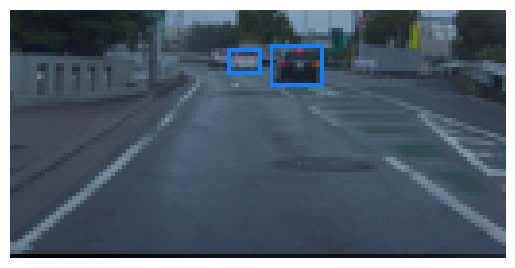

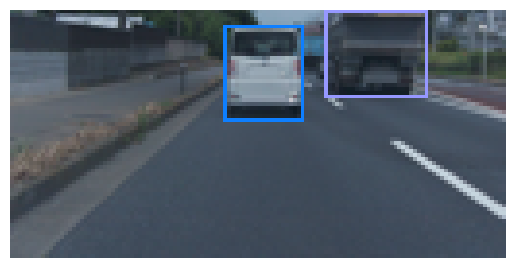

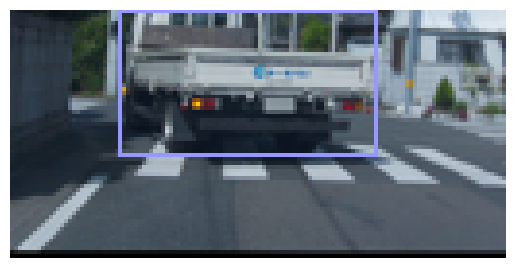

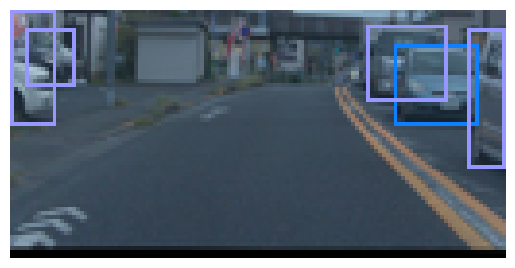

In [12]:
import json

from ultralytics import YOLO

# cmap
cmap = np.array(plt.cm.get_cmap("tab20").colors) * 255

# モデルの読み込み
model = YOLO("yolo11x.pt")

# 予測の実行
results = model.predict(
    path[:100],
    classes=[0, 1, 2, 3, 5, 7, 9, 11, 12],
    verbose=False,
    conf=0.25,
    # imgsz=1024,
)

for i in range(10):
    img = results[i].orig_img.copy()
    save_data = []
    for box in results[i].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0]
        cls = int(box.cls[0])
        save_data.append(
            {
                "x1": x1,
                "y1": y1,
                "x2": x2,
                "y2": y2,
                "conf": conf,
                "cls": results[i].names[cls],
            }
        )
        cv2.rectangle(img, (x1, y1), (x2, y2), color=cmap[cls], thickness=1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
